In [82]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.misc import imread, imresize
from keras.preprocessing.image import img_to_array, load_img

# Visualizations will be shown inline
%matplotlib inline

In [83]:
data_frame = pd.read_csv("data/driving_log.csv", usecols=[0,1,2,3])

data_frame.describe(include="all")

,center,left,right,steering
count,8036,8036,8036,8036.000000
unique,8036,8036,8036,NaN
top,IMG/center_2016_12_01_13_44_26_955.jpg,IMG/left_2016_12_01_13_34_09_485.jpg,IMG/right_2016_12_01_13_39_15_686.jpg,NaN
freq,1,1,1,NaN
mean,NaN,NaN,NaN,0.004070
std,NaN,NaN,NaN,0.128840
min,NaN,NaN,NaN,-0.942695
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ef51f98>]], dtype=object)

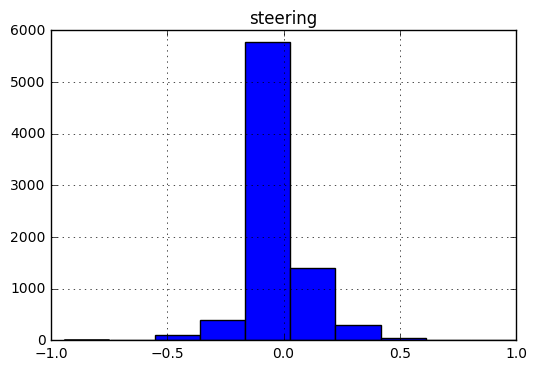

In [84]:
data_frame.hist(column="steering")

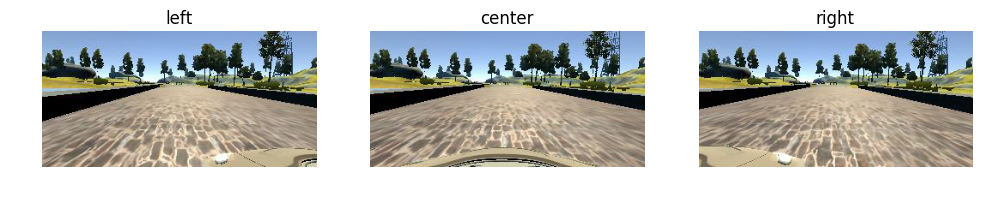

In [85]:
from keras.preprocessing.image import img_to_array, load_img

plt.rcParams['figure.figsize'] = (12, 6)

i = 0
for camera in ["left", "center", "right"]:
    image = load_img("data/"+data_frame.iloc[0][camera].strip())
    image = img_to_array(image).astype(np.uint8)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(camera)
    i += 1

In [86]:
# Remove header
data_frame = data_frame.ix[1:]

# shuffle the data (frac=1 meand 100% of the data)
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

In [87]:
# 80-20 training validation split
training_split = 0.8

num_rows_training = int(data_frame.shape[0]*training_split)

training_data = data_frame.loc[0:num_rows_training-1]
validation_data = data_frame.loc[num_rows_training:]

# release the main data_frame from memory
data_frame = None

In [94]:
def read_images(img_paths):
    imgs = np.empty([len(img_paths), 160, 320, 3])

    for i, path in enumerate(img_paths):
        imgs[i] = imread("data/" + path)

    return imgs

In [163]:
def resize(imgs, shape=(32, 16, 3)):
    """
    Resize images to shape.
    """
    height, width, channels = shape
    imgs_resized = np.empty([len(imgs), height, width, channels])
    for i, img in enumerate(imgs):
        imgs_resized[i] = imresize(img, shape)
        #imgs_resized[i] = cv2.resize(img, (16, 32))

    return imgs_resized

In [191]:
def normalize(imgs):
    """
    Normalize images between [-1, 1].
    """
    #return imgs / (255.0 / 2) - 1
    return imgs / 255.0 - 0.5

In [192]:
def preprocess(imgs):
    #imgs_processed = resize(imgs)
    #imgs_processed = rgb2gray(imgs_processed)
    imgs_processed = normalize(imgs)

    return imgs_processed

In [193]:
def gen_batches(data_frame, batch_size):
    """
    Generates random batches of the input data.

    :param imgs: The input images.
    :param angles: The steering angles associated with each image.
    :param batch_size: The size of each minibatch.

    :yield: A tuple (images, angles), where both images and angles have batch_size elements.
    """

    #while True:
    df_batch = data_frame.sample(n=batch_size)
    
    images_raw = read_images(df_batch["center"])
    angles_raw = df_batch.as_matrix(columns=["steering"]).astype(float)
    
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images_raw[i].astype("uint8"))
        plt.axis("off")
        plt.title(angles_raw[i])
    
    #print(batch_imgs_raw)
    plt.figure()
    batch_imgs, batch_angles = preprocess(images_raw), angles_raw
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(batch_imgs[i].astype("uint8"))
        plt.axis('off')
        plt.title(batch_angles[i])
        
    #batch_imgs, batch_angles = augment(preprocess(batch_imgs_raw), angles_raw)
    #    batch_imgs, batch_angles = augment(batch_imgs_raw, angles_raw)
    #    batch_imgs = preprocess(batch_imgs)

    #    yield batch_imgs, batch_angles

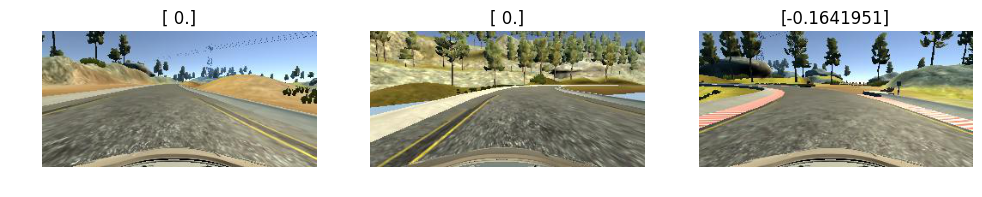

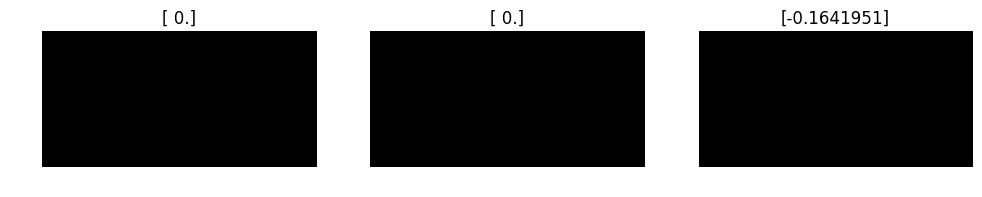

In [195]:
gen_batches(training_data, 128)
#gen_batches(validation_data, 128)